In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

import polars as pl
import numpy as np

from adex.models import Condition, ConditionDataLoader, ConditionSequencingTissueDataLoader, \
    ConditionSequencingDataLoader, SequencingTechnique, TissueEnum, METADATA_COLUMNS, FileDataLoader, DataLoader
from adex.helpers import get_pre_processed_dataset, run_ml_model
from adex.models import DATASET_INFO_COLUMNS
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score

data_path = "../data/adex-database/samples"
metadata_path = "../data/adex-database/metadata.csv"
datasets_info_path = "../data/adex-database/datasets_info.csv"
results_path = "../results"

# Prepare Data

In [94]:
top10_de_genes_ra_GSE89408 = (
    pl
    .read_csv(f"../data/ml/GSE89408_top_de_train_genes.csv", has_header=True)
    .to_series()
    .to_list()
)
len(top10_de_genes_ra_GSE89408)

10

In [95]:
top_de_genes_ra_GSE89408 = (
    pl
    .read_csv(f"../results/GSE89408_only_train_samples/edgeR_de_genes.csv", has_header=True)
    .to_series()
    .to_list()
)
len(top_de_genes_ra_GSE89408)

148

In [96]:
de_GSE89408 = (
    get_pre_processed_dataset(
        data_loader=FileDataLoader(
            condition=Condition.RA,
            file_name="GSE89408.tsv.parquet",
            genes=['AC017083.2', 'U62317.1', 'AC025423.4']
        ),
        data_path=data_path,
        metadata_path=metadata_path,
        datasets_info_path=datasets_info_path,
        return_metadata=True
    ).fill_null(value=0)
    .drop(filter(lambda item: item != 'Condition',METADATA_COLUMNS)) # We need only the condition from Metadata  
    .drop(DATASET_INFO_COLUMNS)
    .with_columns(
        pl.col("Condition")
            .map_elements(lambda x: 0 if x == "Healthy" else 1, return_dtype=pl.Int8)
            .alias("class_label")
    )
    .drop("Condition")
).sort("Sample")  # Remove randomness at this point 
de_GSE89408

Sample,AC017083.2,U62317.1,AC025423.4,class_label
str,f64,f64,f64,i8
"""GSM2370970""",0.0,0.0,0.0,0
"""GSM2370971""",7.938222,0.0,7.707919,0
"""GSM2370972""",7.53651,0.858757,6.148911,0
"""GSM2370973""",0.0,1.069102,5.776321,0
"""GSM2370974""",5.758763,0.0,4.476259,0
…,…,…,…,…
"""GSM2371183""",7.564782,2.794609,7.378751,1
"""GSM2371184""",8.341194,3.255327,7.99071,1
"""GSM2371185""",7.450259,3.103816,8.041741,1


In [97]:
x_df = (
        de_GSE89408.select([
            pl.all().exclude("Sample", "class_label"),
        ]).to_pandas()
 )
x_df

,AC017083.2,U62317.1,AC025423.4
0,0.000000,0.000000,0.000000
1,7.938222,0.000000,7.707919
2,7.536510,0.858757,6.148911
3,0.000000,1.069102,5.776321
4,5.758763,0.000000,4.476259
...,...,...,...
175,7.564782,2.794609,7.378751
176,8.341194,3.255327,7.990710
177,7.450259,3.103816,8.041741
178,7.930536,2.795792,7.969548


In [98]:
y_df = de_GSE89408.select(pl.col("class_label").alias("y")).to_pandas()
y_df

,y
0,0
1,0
2,0
3,0
4,0
...,...
175,1
176,1
177,1
178,1


In [99]:
x_train, _, y_train, _ = model_selection.train_test_split(
    x_df, y_df, 
    train_size=0.7, 
    random_state=42,  # Ensure a reproducible split 
    shuffle=True, 
    stratify=y_df  # solve the class imbalance issue 
)

In [100]:
x_train

,AC017083.2,U62317.1,AC025423.4
13,0.000000,1.864341,4.348193
73,7.122238,5.518350,6.921170
4,5.758763,0.000000,4.476259
5,5.965939,3.491997,7.195406
57,5.156864,3.369568,6.887080
...,...,...,...
53,7.649072,4.026287,7.152249
64,7.112296,3.523430,7.582939
176,8.341194,3.255327,7.990710
89,7.224499,6.023392,8.236785


In [101]:
y_train

,y
13,0
73,1
4,0
5,0
57,1
...,...
53,1
64,1
176,1
89,1


In [102]:
y_train.value_counts()

y
1    106
0     19
Name: count, dtype: int64

In [103]:
other_dataset = (
    get_pre_processed_dataset(
        data_loader=FileDataLoader(
            condition=Condition.RA,
            file_name="GSE90081.tsv.parquet",
            genes=['AC017083.2', 'U62317.1', 'AC025423.4']
        ),
        data_path=data_path,
        metadata_path=metadata_path,
        datasets_info_path=datasets_info_path,
        return_metadata=True
    ).fill_null(value=0)
    .drop(filter(lambda item: item != 'Condition',METADATA_COLUMNS)) # We need only the condition from Metadata  
    .drop(DATASET_INFO_COLUMNS)
    .with_columns(
        pl.col("Condition")
        .map_elements(lambda x: 0 if x == "Healthy" else 1, return_dtype=pl.Int8)
        .alias("class_label")
    )
    .drop("Condition")
).sort("Sample")  # Remove randomness at this point 
other_dataset

Sample,AC017083.2,U62317.1,AC025423.4,class_label
str,f64,f64,f64,i8
"""GSM2397368""",3.481152,3.945145,1.430005,1
"""GSM2397369""",3.460948,3.592805,3.066424,1
"""GSM2397370""",4.618138,3.785423,3.919814,1
"""GSM2397371""",3.522376,3.522376,3.148595,1
"""GSM2397372""",5.192835,4.364799,5.134392,1
…,…,…,…,…
"""GSM2397387""",3.325761,2.957906,4.487884,1
"""GSM2397388""",4.819667,3.535223,3.535223,1
"""GSM2397389""",3.598231,5.445981,4.142929,1


In [104]:
x_test = other_dataset.drop("Sample").drop("class_label")
x_test

AC017083.2,U62317.1,AC025423.4
f64,f64,f64
3.481152,3.945145,1.430005
3.460948,3.592805,3.066424
4.618138,3.785423,3.919814
3.522376,3.522376,3.148595
5.192835,4.364799,5.134392
…,…,…
3.325761,2.957906,4.487884
4.819667,3.535223,3.535223
3.598231,5.445981,4.142929


In [105]:
y_test = other_dataset.select("class_label")
y_test

class_label
i8
1
1
1
1
1
…
1
1
1


# Logistic Regression 

Default Parameters of Base Model: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Parameters for tuning provided: {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Cross Validation Scores (cv=4): 0.9375,1.0,0.967741935483871,0.9354838709677419
Cross Validation gives 0.96 accuracy with a standard deviation of 0.03

Metrics on the Test Set:

        Accuracy: 0.625
    

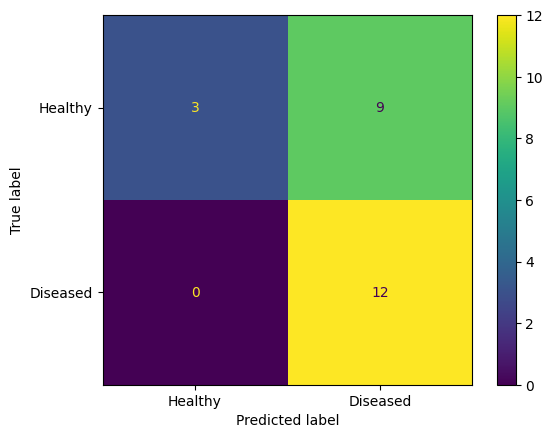

In [106]:
logistic_model, _ = run_ml_model(
    classifier=LogisticRegression(solver='liblinear', random_state=0),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
)

In [107]:
logistic_model.intercept_

array([-5.02382292])

In [108]:
logistic_model.coef_

array([[0.37582769, 0.87221342, 0.44561521]])

In [109]:
logistic_model.predict_proba(x_test)

array([[0.41029871, 0.58970129],
       [0.31495921, 0.68504079],
       [0.14676195, 0.85323805],
       [0.3153317 , 0.6846683 ],
       [0.04640693, 0.95359307],
       [0.76134282, 0.23865718],
       [0.4688357 , 0.5311643 ],
       [0.32705808, 0.67294192],
       [0.7469313 , 0.2530687 ],
       [0.13144401, 0.86855599],
       [0.47884646, 0.52115354],
       [0.34838539, 0.65161461],
       [0.14711577, 0.85288423],
       [0.55637133, 0.44362867],
       [0.19711241, 0.80288759],
       [0.27443276, 0.72556724],
       [0.31414371, 0.68585629],
       [0.49991566, 0.50008434],
       [0.06900134, 0.93099866],
       [0.30876818, 0.69123182],
       [0.19056255, 0.80943745],
       [0.05094589, 0.94905411],
       [0.14750358, 0.85249642],
       [0.2017214 , 0.7982786 ]])

# Decision Tree 

Default Parameters of Base Model: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
Parameters for tuning provided: {'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 4 folds for each of 36 candidates, totalling 144 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
Cross Validation Scores (cv=4): 0.9375,1.0,0.9354838709677419,0.9032258064516129
Cross Validation give

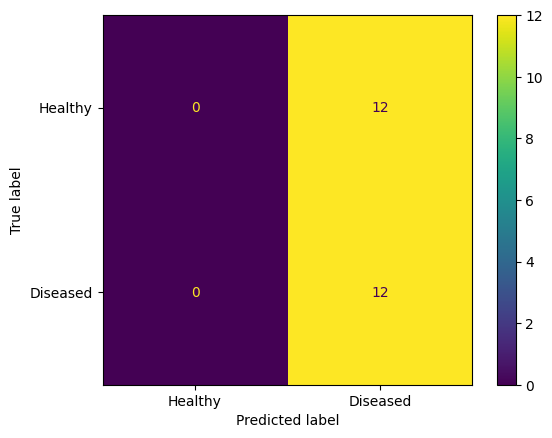

In [110]:
from sklearn import tree

tree_model, _ = run_ml_model(
    classifier=tree.DecisionTreeClassifier(),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    param_grid={
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
)

[Text(0.5, 0.875, 'x[2] <= 6.158\ngini = 0.258\nsamples = 125\nvalue = [19, 106]'),
 Text(0.3, 0.625, 'x[0] <= 7.693\ngini = 0.308\nsamples = 21\nvalue = [17, 4]'),
 Text(0.2, 0.375, 'x[1] <= 2.041\ngini = 0.188\nsamples = 19\nvalue = [17, 2]'),
 Text(0.1, 0.125, 'gini = 0.0\nsamples = 17\nvalue = [17, 0]'),
 Text(0.3, 0.125, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.4, 0.375, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.7, 0.625, 'x[1] <= 0.422\ngini = 0.038\nsamples = 104\nvalue = [2, 102]'),
 Text(0.6, 0.375, 'gini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(0.8, 0.375, 'x[0] <= 6.03\ngini = 0.02\nsamples = 99\nvalue = [1, 98]'),
 Text(0.7, 0.125, 'gini = 0.219\nsamples = 8\nvalue = [1, 7]'),
 Text(0.9, 0.125, 'gini = 0.0\nsamples = 91\nvalue = [0, 91]')]

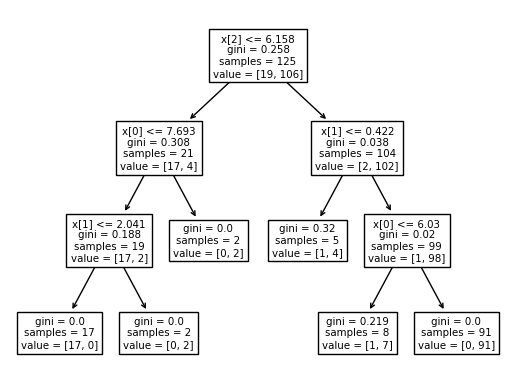

In [111]:
tree.plot_tree(tree_model)

# Gradient boosted Tree

Default Parameters of Base Model: {'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': None, 'max_features': 1.0, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Parameters for tuning provided: {'max_iter': [100, 1000, 1500], 'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [25, 50, 75], 'l2_regularization': [0.0, 1.5]}
Fitting 4 folds for each of 54 candidates, totalling 216 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': 25, 'max_featu

(HistGradientBoostingClassifier(max_depth=25),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1], dtype=int8))

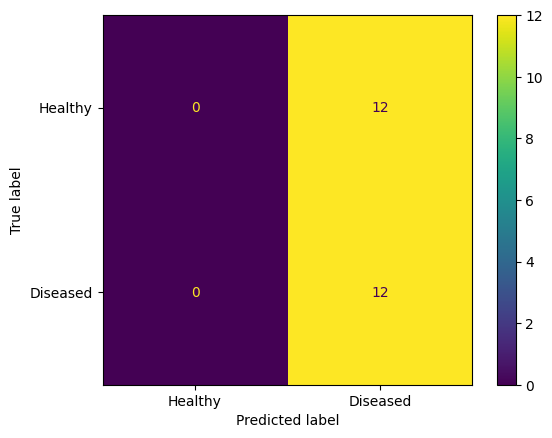

In [112]:
from sklearn.ensemble import HistGradientBoostingClassifier

run_ml_model(
    classifier=HistGradientBoostingClassifier(max_iter=100), 
    x_train=x_train, 
    y_train=y_train, 
    x_test=x_test, 
    y_test=y_test,
    param_grid={
        "max_iter": [100, 1000, 1500],
        "learning_rate": [0.1, 0.2, 0.3],
        "max_depth": [25, 50, 75],
        "l2_regularization": [0.0, 1.5]
    }
)

# Random Forest 

Default Parameters of Base Model: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Parameters for tuning provided: {'bootstrap': [True, False], 'max_depth': [10, 50, 100, None], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [10, 100, 1000]}
Fitting 4 folds for each of 216 candidates, totalling 864 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_s

(RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2,
                        n_estimators=10),
 array([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1], dtype=int8))

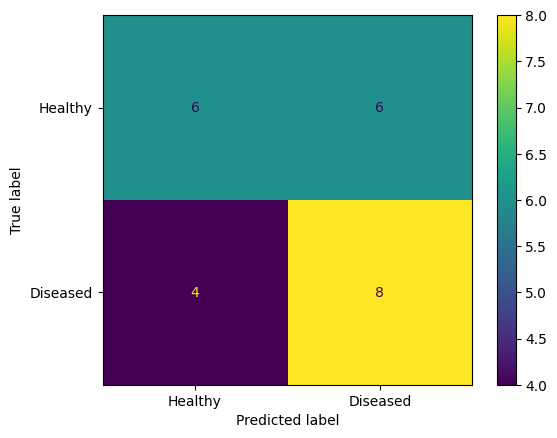

In [113]:
from sklearn.ensemble import RandomForestClassifier

# worst than using the defaults 
run_ml_model(
    classifier=RandomForestClassifier(n_estimators=10),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    param_grid={
        'bootstrap': [True, False],
        'max_depth': [10, 50, 100, None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [10, 100, 1000]
    }
)

Default Parameters of Base Model: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Running with base model
Cross Validation Scores (cv=4): 0.90625,1.0,0.967741935483871,0.9032258064516129
Cross Validation gives 0.94 accuracy with a standard deviation of 0.04

Metrics on the Test Set:

        Accuracy: 0.5416666666666666
        Precision: 0.5217391304347826
        Recall: 1.0
        f1: 0.6857142857142857
    


(RandomForestClassifier(n_estimators=10),
 array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1], dtype=int8))

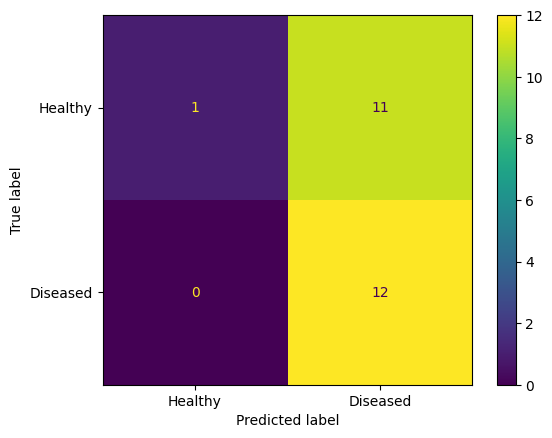

In [114]:
run_ml_model(
    classifier=RandomForestClassifier(n_estimators=10),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

# SVMs

Default Parameters of Base Model: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Parameters for tuning provided: {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Cross Validation Scores (cv=4): 0.90625,1.0,0.967741935483871,0.9354838709677419
Cross Validation gives 0.95 accuracy with a standard deviation of 0.04

Metrics on the Test Se

(SVC(C=10, gamma=0.001),
 array([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0], dtype=int8))

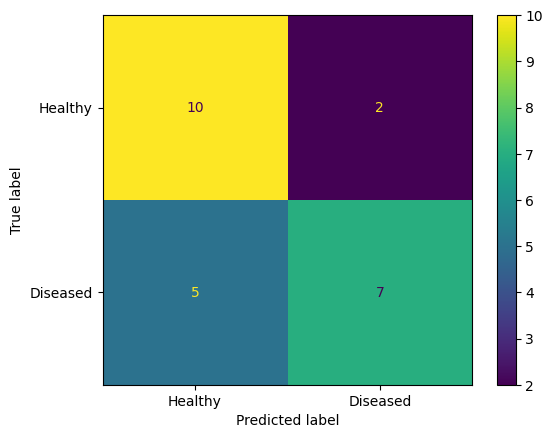

In [115]:
from sklearn import svm

run_ml_model(
    classifier=svm.SVC(),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    param_grid={
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
    }
)